In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape
import keras
import keras.backend as K
import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

W0627 11:45:54.790189 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0627 11:45:54.791280 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0627 11:45:54.829572 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [133]:
df = pd.read_csv('robolee/Data/AAPL.csv', index_col='datetime')
data_cols = ['close', 'high', 'low', 'open', 'volume']
df = df[data_cols]
np.diff(df.index[:100])

array([  900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
       30600000,  1800000,   900000,   900000,  1800000,  1800000,
         900000,  1800000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000, 29700000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900000,
         900000,   900000,   900000,   900000,   900000,   900

In [5]:
df_scaled = df.apply(minmax_scale)
df_scaled[:5]

,close,high,low,open,volume
datetime,,,,,
1545169500000,0.314077,0.318044,0.316858,0.319206,0.001225
1545170400000,0.310655,0.314211,0.313406,0.312222,0.000667
1545171300000,0.314625,0.311062,0.312025,0.311400,0.000326
1545172200000,0.313393,0.311473,0.310783,0.314824,0.000510
1545173100000,0.311339,0.325849,0.313406,0.311400,0.000144


In [19]:
def compute_log_returns(datum):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    # TODO: Implement Function
    
    return np.log(datum) - np.log(datum.shift(1))

In [34]:
transformed_df = compute_log_returns(df).dropna()
transformed_df[:5]

,close,high,low,open,volume
datetime,,,,,
1545170400000,-0.001517,-0.001693,-0.001517,-0.003090,-0.604453
1545171300000,0.001759,-0.001393,-0.000607,-0.000364,-0.709193
1545172200000,-0.000546,0.000182,-0.000547,0.001516,0.442702
1545173100000,-0.000910,0.006343,0.001154,-0.001516,-1.241720
1545174000000,0.000849,-0.006828,0.000061,0.000000,0.159048


In [32]:
x_scaled = transformed_df[['high','low','open','volume']].apply(minmax_scale)
x_scaled[:5]

,high,low,open,volume
datetime,,,,
1545170400000,0.760805,0.751690,0.789352,0.429512
1545171300000,0.762177,0.755740,0.802367,0.423692
1545172200000,0.769387,0.756009,0.811347,0.487701
1545173100000,0.797594,0.763587,0.796866,0.394100
1545174000000,0.737296,0.758716,0.804106,0.471938


In [48]:
xy_scaled = pd.concat([transformed_df[['close']], x_scaled], axis=1)
xy_scaled[:5]


,close,high,low,open,volume
datetime,,,,,
1545170400000,-0.001517,0.760805,0.751690,0.789352,0.429512
1545171300000,0.001759,0.762177,0.755740,0.802367,0.423692
1545172200000,-0.000546,0.769387,0.756009,0.811347,0.487701
1545173100000,-0.000910,0.797594,0.763587,0.796866,0.394100
1545174000000,0.000849,0.737296,0.758716,0.804106,0.471938


In [49]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [50]:
window_size = 24

X, y = create_multivariate_rnn_data(xy_scaled, window_size=window_size)


In [51]:
X.shape, y.shape


((174589, 24, 5), (174589, 5))

In [52]:
test_size =24
train_size = X.shape[0]-test_size

In [53]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [54]:
X_train.shape, X_test.shape

((174565, 24, 5), (24, 24, 5))

In [55]:
n_features = output_size = 5

In [56]:
lstm1_units = 12
lstm2_units = 6

In [57]:
rnn = Sequential([
    LSTM(units=lstm1_units,
         dropout=.2,
         recurrent_dropout=.2,
         input_shape=(window_size, n_features), name='LSTM1',
         return_sequences=True),
    LSTM(units=lstm2_units,
         dropout=.2,
         recurrent_dropout=.2,
         name='LSTM2'),
    Dense(10, name='FC1'),
    Dense(output_size, name='Output')
])

W0627 13:38:05.917026 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 13:38:05.950074 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 13:38:06.119823 4553258432 deprecation.py:506] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [58]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 24, 12)            864       
_________________________________________________________________
LSTM2 (LSTM)                 (None, 6)                 456       
_________________________________________________________________
FC1 (Dense)                  (None, 10)                70        
_________________________________________________________________
Output (Dense)               (None, 5)                 55        
Total params: 1,445
Trainable params: 1,445
Non-trainable params: 0
_________________________________________________________________


In [59]:
rnn.compile(loss='mae', optimizer='RMSProp')

W0627 13:38:56.609152 4553258432 deprecation_wrapper.py:119] From /Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [60]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

In [61]:
rnn_path = 'models/fred.lstm_{}_{}.weights.best.hdf5'.format(lstm1_units, lstm2_units)
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [120]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=50,
                 batch_size=20,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Train on 174565 samples, validate on 24 samples
Epoch 1/50
174565/174565 [==============================] - 375s 2ms/step - loss: 0.0149 - val_loss: 0.0170
Epoch 2/50
 20560/174565 [==>...........................] - ETA: 5:00 - loss: 0.0151

KeyboardInterrupt: 

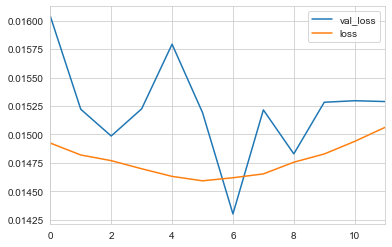

In [71]:
pd.DataFrame(result.history).plot();


In [72]:
y_pred = pd.DataFrame(rnn.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1561485600000 to 1561506300000
Data columns (total 5 columns):
close     24 non-null float32
high      24 non-null float32
low       24 non-null float32
open      24 non-null float32
volume    24 non-null float32
dtypes: float32(5)
memory usage: 672.0 bytes


In [73]:
test_mae = mean_absolute_error(y_pred, y_test)


In [117]:
# pd.DataFrame(result.history).plot()
y_train.iloc[2:, 'close']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

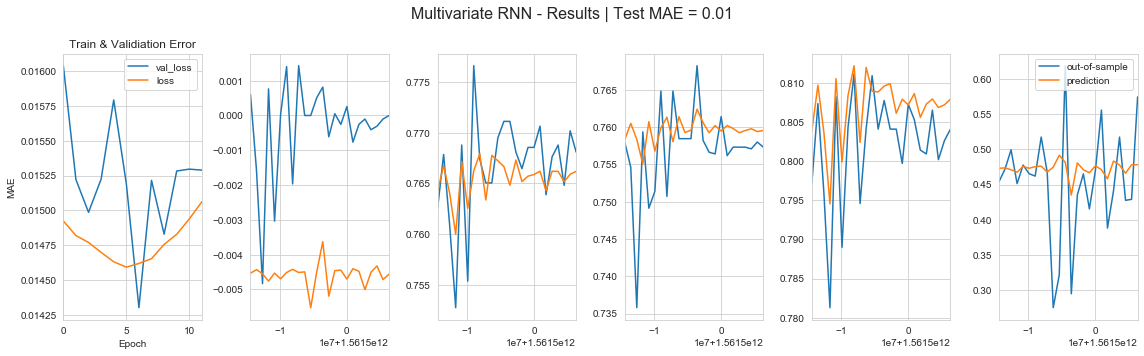

In [119]:
fig, axes = plt.subplots(ncols=6, figsize=(16, 5))
pd.DataFrame(result.history).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
for i, col in enumerate(y_test.columns, 1):
#     y_train.iloc[1561457700000:, col].plot(ax=axes[i], label='training', title=col)
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')
plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.2f}'.format(test_mae), fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.85)
# fig.savefig('figures/multivariate_results', dpi=300);